# MiniLab 1: Fuel Consumption Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from isc301.config import fuel_consumption_raw_path

In [2]:
df = pd.read_csv(fuel_consumption_raw_path)
df.head()

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km)
0,1995,Acura,Integra,Subcompact,1.8,4,A4,X,10.2,7.0,8.8,32,202
1,1995,Acura,Integra,Subcompact,1.8,4,M5,X,9.6,7.0,8.4,34,193
2,1995,Acura,Integra GS-R,Subcompact,1.8,4,M5,Z,9.4,7.0,8.3,34,191
3,1995,Acura,Legend,Compact,3.2,6,A4,Z,12.6,8.9,10.9,26,251
4,1995,Acura,Legend Coupe,Compact,3.2,6,A4,Z,13.0,9.3,11.3,25,260


## Exploration

<Axes: xlabel='Combined (L/100 km)', ylabel='CO2 emissions (g/km)'>

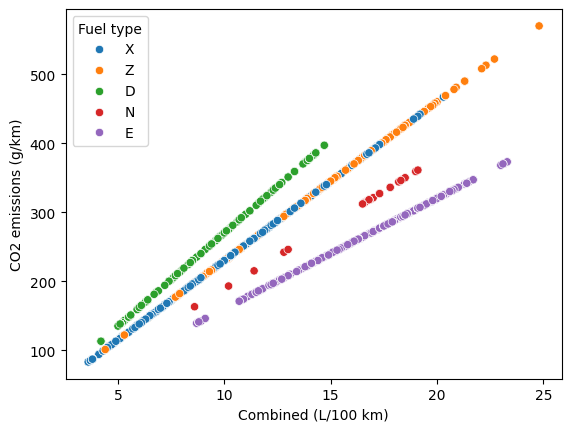

In [3]:
sns.scatterplot(df, x="Combined (L/100 km)", y="CO2 emissions (g/km)", hue="Fuel type")

<Axes: >

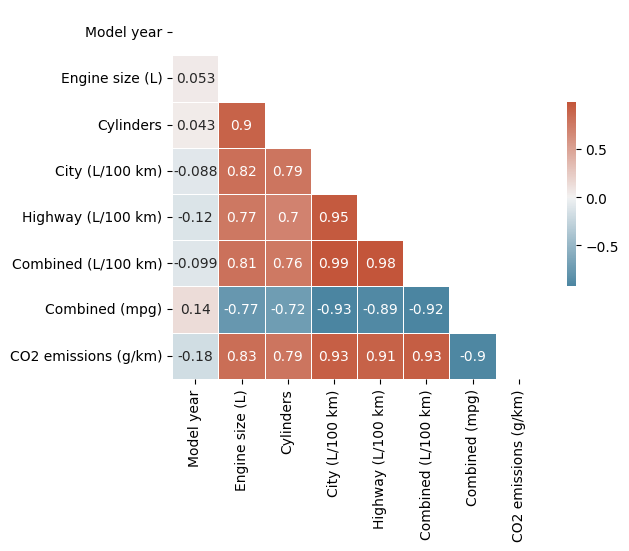

In [4]:
num_df = df[
    [
        "Model year",
        "Engine size (L)",
        "Cylinders",
        "City (L/100 km)",
        "Highway (L/100 km)",
        "Combined (L/100 km)",
        "Combined (mpg)",
        "CO2 emissions (g/km)",
    ]
]
corr = num_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    center=0,
    annot=True,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

### Observations
**Highly correlated variables**
- Cylinders <-> Engine Size
- Consumption <-> CO2 emissions

Combined (miles / gallon) is the inverse of consumption => correlations are negative

Model year doesn't seem to bring much information about CO2 emissions

## Model

In [5]:
from typing import Callable
import matplotlib.pyplot as plt

In [6]:
Model = Callable[[float], float]


def model_lin(a: float) -> Model:
    def model(x: float) -> float:
        return x * a

    return model

a=10, mse=np.float64(20791.112968591693)
a=20, mse=np.float64(1317.4233367105708)
a=30, mse=np.float64(8384.685185185184)


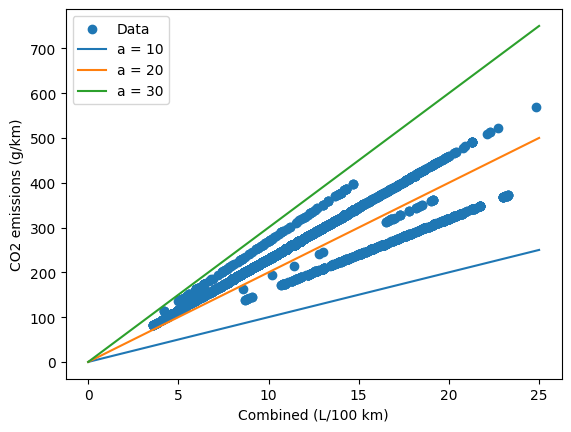

In [7]:
co2: np.ndarray = df["CO2 emissions (g/km)"]
combined: np.ndarray = df["Combined (L/100 km)"]


def evaluate(model: Model, data_x: np.ndarray, data_y: np.ndarray) -> float:
    y: np.ndarray = model(data_x)
    mse: float = ((y - data_y) ** 2).mean()
    return mse


def plot_model():
    x: np.ndarray = np.linspace(0, 25)
    plt.scatter(combined, co2, label="Data")
    for a in [10, 20, 30]:
        model: Model = model_lin(a)
        y: np.ndarray = model(x)
        mse: float = evaluate(model, combined, co2)
        print(f"{a=}, {mse=}")
        plt.plot(x, y, label=f"a = {a}")
    plt.legend()
    plt.xlabel("Combined (L/100 km)")
    plt.ylabel("CO2 emissions (g/km)")
    plt.show()


plot_model()

### Best model
To find the best linear model, we can do a linear regression with the Least Square Method

#### LSM
For a model defined as $y = ax + b$, we can compute optimal parameters as follows:

$$
\displaystyle
\begin{aligned}
a' &= \frac{\frac{1}{n} \sum x_i y_i - \overline{x}\centerdot\overline{y}}{\frac{1}{n} \sum {x_i}^2 - \overline{x}^2}\\
b' &= \overline{y} - a'\ \overline{x}
\end{aligned}
$$

where $\overline{x}$ is the mean value of all $x_i$, and $\overline{y}$ is the mean value of all $y_i$


For a model defined as $y = ax$, we can compute optimal parameters as follows:

$$
\displaystyle
\begin{align}
y_i &= a x_i + \epsilon_i\\
\epsilon_i &= y_i - a x_i\\
\sum \epsilon_i^2 &= \sum (y_i - a x_i)^2 = S(a)
\end{align}
$$

$$
\frac{dS}{da} = 0 \Leftrightarrow \sum 2(y_i - a x_i) (-x_i) = 0
$$
Thus,
$$
\begin{align}
&\sum a x_i^2 - \sum x_i y_i = 0\\
\Rightarrow &a = \frac{\sum x_i y_i}{\sum x_i^2}
\end{align}
$$

In [8]:
def lsm(data_x: np.ndarray, data_y: np.ndarray) -> float:
    # mean_x: float = data_x.mean()
    # mean_y: float = data_y.mean()
    # denom: float = (data_x * data_y).mean() - mean_x * mean_y
    # num: float = (data_x**2).mean() - mean_x * mean_x
    denom: float = (data_x * data_y).sum()
    num: float = (data_x * data_x).sum()
    return denom / num

a=np.float64(22.337223628284217) mse=np.float64(592.5084327610823)


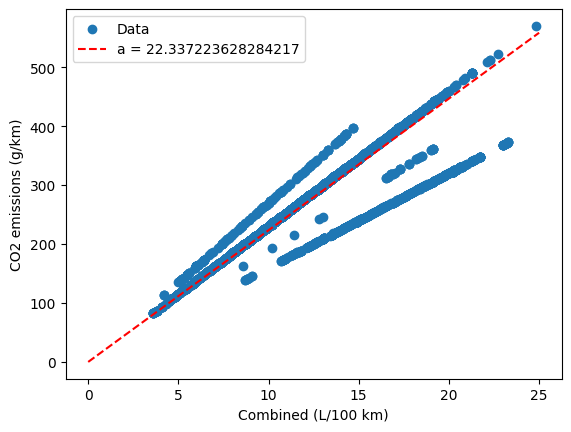

In [9]:
def plot_lsm():
    x: np.ndarray = np.linspace(0, 25)
    plt.scatter(combined, co2, label="Data")
    a: float = lsm(combined, co2)
    model: Model = model_lin(a)
    y: np.ndarray = model(x)
    mse: float = evaluate(model, combined, co2)
    print(f"{a=} {mse=}")
    plt.plot(x, y, label=f"a = {a}", c="r", linestyle="--")
    plt.legend()
    plt.xlabel("Combined (L/100 km)")
    plt.ylabel("CO2 emissions (g/km)")
    plt.show()


plot_lsm()

#### Newton
We can also use Newton's method to minimize the error of our model. For this, let's take the following function
$$ f(a) = \text{MSE}'(\text{Model}_a) $$
We thus want to find a root of $f$
We can construct the following series, which converges to the root:
$$ x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)} $$
With
<!--$$
\begin{align}
f(a) &= \frac{1}{n} \sum (a x_i - y_i)^2 = \frac{1}{n} \sum (a^2 x_i^2 -2a x_i y_i + y_i^2) \\
\Rightarrow f'(a) &= \frac{1}{n} \sum (2x_i^2 a -2 x_i y_i) = \frac{2}{n} \sum x_i(ax_i - y_i)
\end{align}
$$-->
$$
\begin{align}
f(a) &= \sum (y_i - a x_i) (-x_i) = a \sum x_i^2 - \sum x_i y_i \\
\Rightarrow f'(a) &= \sum x_i^2
\end{align}
$$

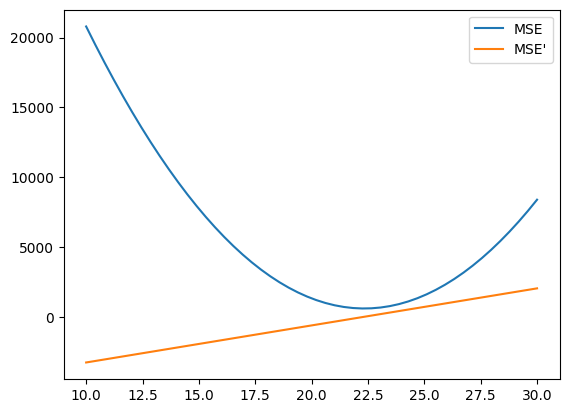

[10,
 np.float64(12.467444725656843),
 np.float64(14.441400506182319),
 np.float64(16.020565130602698),
 np.float64(17.283896830139003),
 np.float64(18.294562189768047),
 np.float64(19.10309447747128),
 np.float64(19.749920307633868),
 np.float64(20.267380971763938),
 np.float64(20.681349503067995),
 np.float64(21.01252432811124),
 np.float64(21.277464188145835),
 np.float64(21.489416076173512),
 np.float64(21.658977586595654),
 np.float64(21.794626794933368),
 np.float64(21.903146161603537),
 np.float64(21.989961654939673),
 np.float64(22.05941404960858),
 np.float64(22.114975965343707),
 np.float64(22.15942549793181),
 np.float64(22.19498512400229)]

In [10]:
def newton(
    data_x: float, data_y: float, start_a: float, iters: int = 20, eta: float = 0.2
) -> list[float]:
    a: float = start_a
    values: list[float] = [a]

    def mse(a: float):
        y: np.ndarray = a * data_x
        return ((y - data_y) ** 2).mean()

    def mse2(a: float):
        return (data_x * (a * data_x - data_y)).mean() * 2

    def f(a: float):
        return a * (data_x * data_x).sum() - (data_x * data_y).sum()

    def f2(a: float):
        return (data_x * data_x).sum()

    for _ in range(iters):
        # a -= mse(a) / mse2(a)
        a -= f(a) / f2(a) * eta
        values.append(a)

    x = np.linspace(10, 30)
    plt.plot(x, [mse(a) for a in x], label="MSE")
    plt.plot(x, [mse2(a) for a in x], label="MSE'")
    plt.legend()
    plt.show()

    return values


newton(combined, co2, 10)

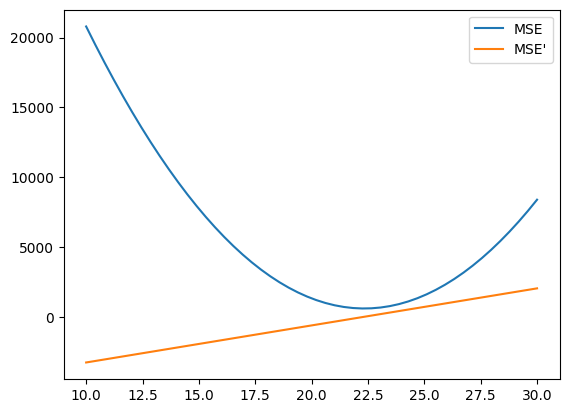

[10, np.float64(12.467444725656843), np.float64(14.441400506182319), np.float64(16.020565130602698), np.float64(17.283896830139003), np.float64(18.294562189768047), np.float64(19.10309447747128), np.float64(19.749920307633868), np.float64(20.267380971763938), np.float64(20.681349503067995), np.float64(21.01252432811124), np.float64(21.277464188145835), np.float64(21.489416076173512), np.float64(21.658977586595654), np.float64(21.794626794933368), np.float64(21.903146161603537), np.float64(21.989961654939673), np.float64(22.05941404960858), np.float64(22.114975965343707), np.float64(22.15942549793181), np.float64(22.19498512400229)]


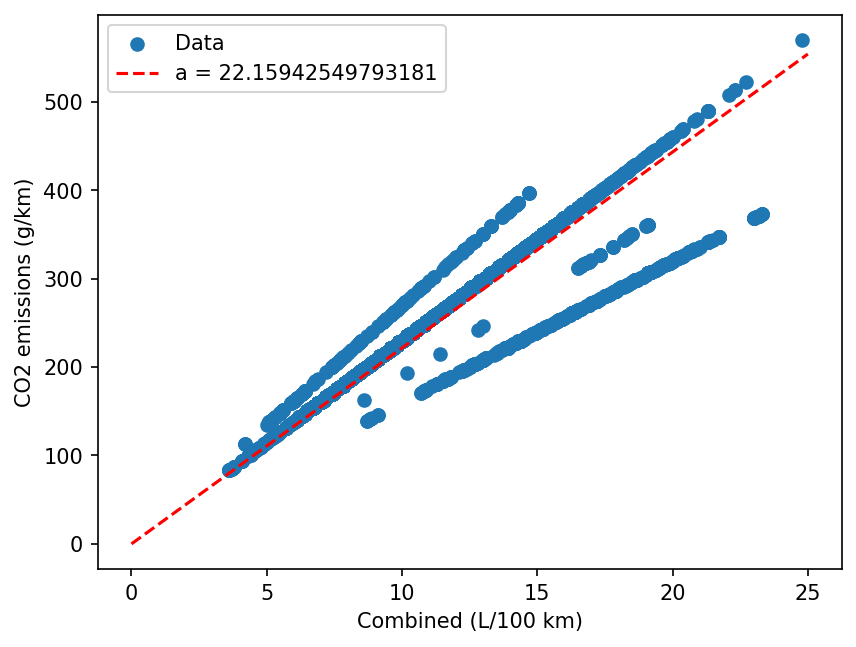

In [11]:
import matplotlib.animation as animation


def plot_newton():
    iters: int = 20
    a_list: list[float] = newton(combined, co2, 10, iters)
    print(a_list)
    plt.rcParams["animation.html"] = "jshtml"
    plt.rcParams["figure.dpi"] = 150
    plt.ioff()
    fig, ax = plt.subplots()
    x: np.ndarray = np.linspace(0, 25)
    s = ax.scatter(combined, co2, label="Data")
    (p,) = ax.plot(x, x, c="r", linestyle="--", label="a = 10")
    plt.legend()
    plt.xlabel("Combined (L/100 km)")
    plt.ylabel("CO2 emissions (g/km)")

    def animate(i):
        a: float = a_list[i]
        model: Model = model_lin(a)
        p.set_label(f"a = {a}")
        p.set_data(x, model(x))
        plt.legend()
        # p = ax.plot(x, model(x), label="a = {a}", c="r", linestyle="--")
        return (s, p)

    return animation.FuncAnimation(
        fig, animate, repeat=True, frames=iters, interval=100
    )


plot_newton()

### Better models
To further improve our model, we could take the fuel type into account. As shown earlier, each fuel type seems to have its own linear model. Since this is a categorical parmeter, it cannot be directly integrated in the mathematical model. One approach could be to convert this categorical data to numbers. An even better approach could be to split the models into multiple parameter sets, one for each fuel type.

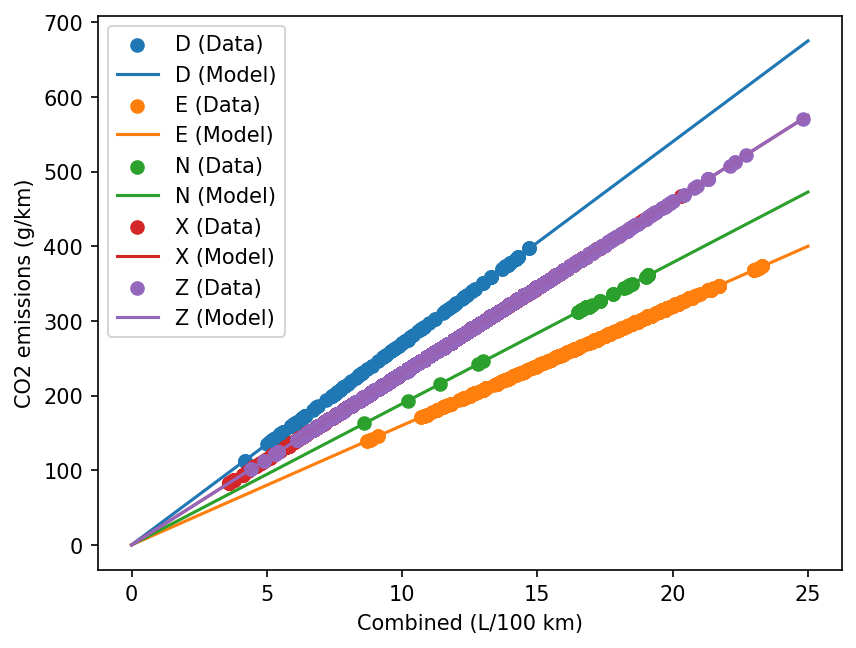

Total MSE = 0.3995710380750422


In [12]:
def by_fuel_type():
    fuel_types = np.unique(df["Fuel type"])
    x: np.ndarray = np.linspace(0, 25)
    total_error: float = 0
    for ft in fuel_types:
        data: pd.DataFrame = df[df["Fuel type"] == ft]
        dx: np.ndarray = data["Combined (L/100 km)"]
        dy: np.ndarray = data["CO2 emissions (g/km)"]
        a: float = lsm(dx, dy)
        model: Model = model_lin(a)
        total_error += evaluate(model, dx, dy)
        plt.scatter(dx, dy, label=f"{ft} (Data)")
        plt.plot(x, model(x), label=f"{ft} (Model)")
    plt.xlabel("Combined (L/100 km)")
    plt.ylabel("CO2 emissions (g/km)")
    plt.legend()
    plt.show()
    print(f"Total MSE = {total_error}")


by_fuel_type()